In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv(r'F:\projects\sentiment\Review.csv')

In [3]:
df.head()

,sentiment,review
0,Negative,I had no background knowledge of this movie be...
1,Negative,I am a huge Jane Austen fan and I ordered the ...
2,Negative,Nothing to say but Wow! Has anyone actually ha...
3,Negative,i like Jane Austin novels. I love Pride and Pr...
4,Negative,In this day and age of incredible special movi...


In [4]:
df.shape

(10000, 2)

# start EDA & text preprocessing

In [5]:
df['sentiment'].value_counts()

sentiment
Negative    5081
Positive    4919
Name: count, dtype: int64

In [6]:
df.duplicated().sum()

10

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

<Axes: xlabel='sentiment'>

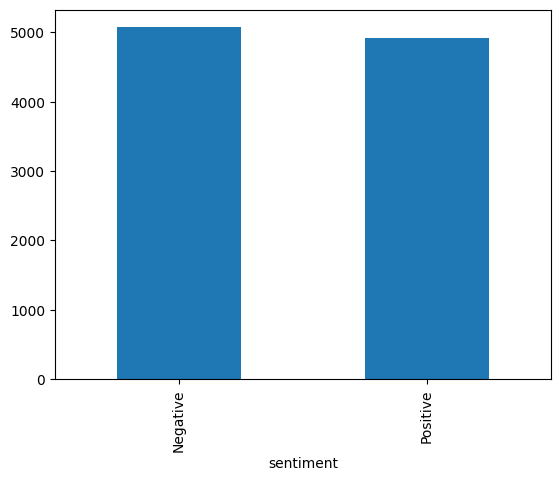

In [9]:
df['sentiment'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'sentiment distribution')

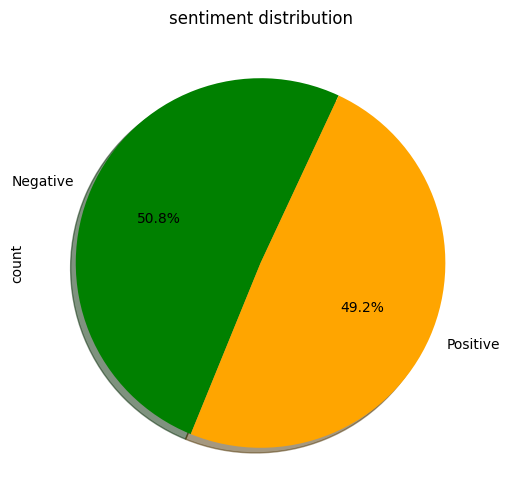

In [10]:
plt.figure(figsize=(8,6))
color = ['green','orange']
df["sentiment"].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,colors=color,startangle=65)
plt.title('sentiment distribution')

# Working with review

In [11]:
df['review']

0       I had no background knowledge of this movie be...
1       I am a huge Jane Austen fan and I ordered the ...
2       Nothing to say but Wow! Has anyone actually ha...
3       i like Jane Austin novels. I love Pride and Pr...
4       In this day and age of incredible special movi...
                              ...                        
9995    I first saw this movie back in the early'90's ...
9996    NYC, 2022: The Greenhouse effect, vanished oce...
9997    Those individuals familiar with Asian cinema, ...
9998    The kids, aged 7 to 14, got such a huge kick o...
9999    I so love this movie! The animation is great (...
Name: review, Length: 9990, dtype: object

In [12]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [13]:
# removing tags 

def remove_tags(text):
    clean_text = re.sub(re.compile('<.*?>'),'',text)
    return clean_text

In [15]:
df['text'] = df['review'].apply(remove_tags)

In [16]:
df['review'].head()

0    I had no background knowledge of this movie be...
1    I am a huge Jane Austen fan and I ordered the ...
2    Nothing to say but Wow! Has anyone actually ha...
3    i like Jane Austin novels. I love Pride and Pr...
4    In this day and age of incredible special movi...
Name: review, dtype: object

In [17]:
# removing punctuation form text

import string
string.punctuation

In [22]:
# removing from text stop words
 
from nltk.corpus import stopwords


In [39]:
stop_list = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
def preprocess_text(text):
    
    text_lower = text.lower()
    
    text_no_punctuation = ''.join([char for char in text_lower if char not in punctuation_set])
 
    words_without_stopwords = [word for word in text_no_punctuation.split() if word not in stop_list]

    processed_text = ' '.join(words_without_stopwords)
    return processed_text

In [42]:
df['text']=df['text'].apply(preprocess_text)

In [43]:
df['text']

0       background knowledge movie bought sounded cool...
1       huge jane austen fan ordered movie amazonuk co...
2       nothing say wow anyone actually somebody sneak...
3       like jane austin novels love pride prejudice s...
4       day age incredible special movie effects one s...
                              ...                        
9995    first saw movie back early90s first released r...
9996    nyc 2022 greenhouse effect vanished oceans gri...
9997    individuals familiar asian cinema whole aware ...
9998    kids aged 7 14 got huge kick film gave copy ki...
9999    love movie animation great pokã©mon movie cgi ...
Name: text, Length: 9990, dtype: object

# Visualizing Negative and Positive Words

In [44]:
from wordcloud import WordCloud

In [45]:
wc = WordCloud(width=1000,height=1000,min_font_size=10,background_color='black')

In [46]:
positive_wc = wc.generate(df[df['sentiment']=='Positive']['review'].str.cat(sep=" "))

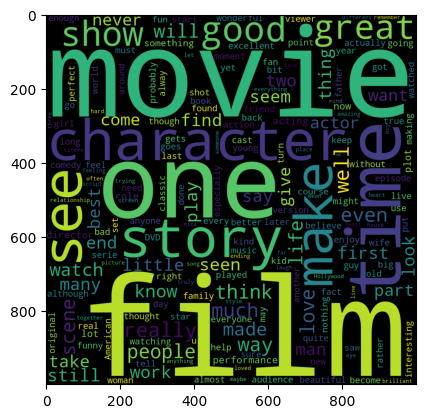

In [47]:
plt.imshow(positive_wc)
plt.show()

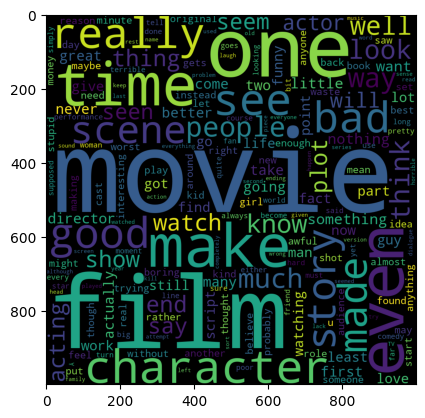

In [48]:
negative_wc = wc.generate(df[df['sentiment']=='Negative']['review'].str.cat(sep=" "))
plt.imshow(negative_wc)
plt.show()

# Lemmatization

In [49]:
from nltk.stem import WordNetLemmatizer

In [50]:
lemmatizer=WordNetLemmatizer()

In [51]:
def lemmatize_text(text):
    if isinstance(text, list):
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in text]
        lemmatized_text = ' '.join(lemmatized_tokens)
    else:
        tokens = nltk.word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [53]:
df['text']=df['text'].apply(lemmatize_text)

# TF-IDF Vectorizer to convert the raw documents into Feature Matrix

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,use_idf=True,norm='l2',smooth_idf=True)

In [57]:
x = tfidf.fit_transform(df.text)

#  covnvert into binary format

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
encoder=LabelEncoder()
y=encoder.fit_transform(df['sentiment'])
y

array([0, 0, 0, ..., 1, 1, 1])

# Train model

In [60]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [61]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(cv=6,scoring='accuracy',random_state=0,n_jobs=1,verbose=3,max_iter=1000)

In [62]:
model.fit(x_train,y_train)

LogisticRegressionCV(cv=6, max_iter=1000, n_jobs=1, random_state=0,
                     scoring='accuracy', verbose=3)

In [63]:
y_pred = model.predict(x_test)

In [64]:
# Accuracy score
from sklearn import metrics

print('Accuracy:',metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.8682015348682015


# prediction

In [80]:
user_review = input('please enter your review')
remove_tag = remove_tags(user_review)
stop_words = preprocess_text(remove_tag)
lemmatized = lemmatize_text(stop_words)
vector = tfidf.transform([lemmatized])
result = model.predict(vector)

if result == 0:
    print('Negative comment 😠')
else:
    print('Positive comment 😊')

Positive comment 😊


In [76]:
df

,sentiment,review,text
0,Negative,I had no background knowledge of this movie be...,background knowledge movie bought sounded cool...
1,Negative,I am a huge Jane Austen fan and I ordered the ...,huge jane austen fan ordered movie amazonuk co...
2,Negative,Nothing to say but Wow! Has anyone actually ha...,nothing say wow anyone actually somebody sneak...
3,Negative,i like Jane Austin novels. I love Pride and Pr...,like jane austin novel love pride prejudice se...
4,Negative,In this day and age of incredible special movi...,day age incredible special movie effect one so...
...,...,...,...
9995,Positive,I first saw this movie back in the early'90's ...,first saw movie back early90s first released r...
9996,Positive,"NYC, 2022: The Greenhouse effect, vanished oce...",nyc 2022 greenhouse effect vanished ocean grin...
9997,Positive,"Those individuals familiar with Asian cinema, ...",individual familiar asian cinema whole aware j...
9998,Positive,"The kids, aged 7 to 14, got such a huge kick o...",kid aged 7 14 got huge kick film gave copy kid...


In [78]:
df['review'][9995]

"I first saw this movie back in the early'90's when it was first released. Room With a View was also newly out. Enchanted April had so much more to offer! I found it much more real and earthy, the characters more believable for being'normal'. By the end of the film I felt the same as I did when I first saw the BBC production of Pride and Prejudice, I was yearning for the characters to find what they were looking for whether it was isolation, peace, liberty or love. You get a sense throughout that Italy is so far removed from everything they have ever known, that they are so decadent for taking a risk and leaving behind all that is humdrum and constricting. But in the heat of the spring in April, everyone's lives loosen and unravel (in line with the Victorian corsets) and are slowly rebuilt to everyone's satisfaction. What a little gem of a film! How come it isn't more well known?"